# 1. Fetching historical Solana Data
Past 30 day data is taken into

In [8]:
import requests
import pandas as pd
from datetime import datetime

def fetch_historical_price_data():
    url = 'https://api.coingecko.com/api/v3/coins/solana/market_chart'
    params = {
        'vs_currency': 'usd',
        'days': 30  # Fetch data for the past 30 days
    }

    response = requests.get(url, params=params)
    if response.status_code == 200:
        data = response.json()
        prices = data['prices']
        # Convert to a pandas DataFrame
        df = pd.DataFrame(prices, columns=['timestamp', 'price'])
        # Convert timestamp to datetime
        df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
        return df
    else:
        print("Failed to fetch data")
        return None

historical_data = fetch_historical_price_data()
if historical_data is not None:
    print(historical_data.head())

                timestamp       price
0 2024-12-11 18:02:43.386  227.785541
1 2024-12-11 19:03:40.686  228.567856
2 2024-12-11 20:06:46.178  230.367760
3 2024-12-11 21:02:33.843  228.947477
4 2024-12-11 22:03:43.899  229.400778


# 2. Data Preprocessing

In [9]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

import requests
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
import numpy as np

def preprocess_data(df):
    # Fill missing values using forward fill
    df.ffill(inplace=True)

    # Normalize the price data
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(df[['price']].values)

    # Create sequences for LSTM
    sequence_length = 60  # Example sequence length
    X, y = [], []
    for i in range(sequence_length, len(scaled_data)):
        X.append(scaled_data[i-sequence_length:i, 0])
        y.append(scaled_data[i, 0])

    X, y = np.array(X), np.array(y)
    return X, y, scaler

# Fetch and preprocess the data
historical_data = fetch_historical_price_data()
if historical_data is not None:
    X, y, scaler = preprocess_data(historical_data)
    print(X.shape, y.shape)
else:
    print("Error fetching or preprocessing data.")

(661, 60) (661,)


# 3. Model

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))  # Prediction of the next price
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Reshape X for LSTM input
X = X.reshape((X.shape[0], X.shape[1], 1))

# Build the LSTM model
model = build_lstm_model((X.shape[1], 1))

# Train the model
model.fit(X, y, epochs=50, batch_size=32)

# Save the model
model.save('lstm_price_prediction_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - loss: 0.0997
Epoch 2/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0124
Epoch 3/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0085
Epoch 4/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0067
Epoch 5/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 0.0068
Epoch 6/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0063
Epoch 7/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0068
Epoch 8/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 0.0056
Epoch 9/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0061
Epoch 10/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0047
Epoch 11/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0063
Epoch 12/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0056
Epoch 13/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0048
Epoch 14/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0055
Epoch 15/50
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0047
Epoc

# 4. Backtesting

21/21 ━━━━━━━━━━━━━━━━━━━━ 4s 104ms/step
Mean Squared Error: 9.518893990559844
Up/Down Prediction Accuracy: 0.5060606060606061


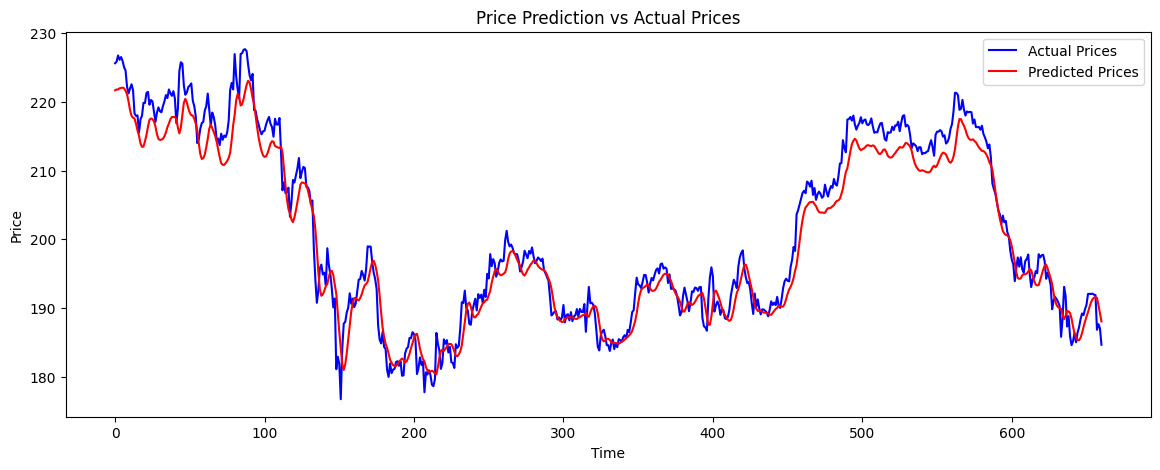

In [7]:
from sklearn.metrics import mean_squared_error, accuracy_score
import matplotlib.pyplot as plt

def backtest_model(model, X, y, scaler):
    # Make predictions
    predictions = model.predict(X)
    predictions = scaler.inverse_transform(predictions)
    actual_prices = scaler.inverse_transform(y.reshape(-1, 1))

    # Calculate Mean Squared Error
    mse = mean_squared_error(actual_prices, predictions)
    print(f"Mean Squared Error: {mse}")

    # Calculate accuracy for up/down prediction
    up_down_predictions = (predictions[1:] > predictions[:-1]).astype(int)
    up_down_actuals = (actual_prices[1:] > actual_prices[:-1]).astype(int)
    accuracy = accuracy_score(up_down_actuals, up_down_predictions)
    print(f"Up/Down Prediction Accuracy: {accuracy}")

    # Plot predictions vs actual prices
    plt.figure(figsize=(14, 5))
    plt.plot(actual_prices, color='blue', label='Actual Prices')
    plt.plot(predictions, color='red', label='Predicted Prices')
    plt.title('Price Prediction vs Actual Prices')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

# Backtesting the model
backtest_model(model, X, y, scaler)